In [5]:
from scipy import signal
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import numpy as np
import torch
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from librosa import display
from IPython.display import Audio
import librosa
import collections
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Preprocess: convert to log-mel spectrogram

Size: 790
44100


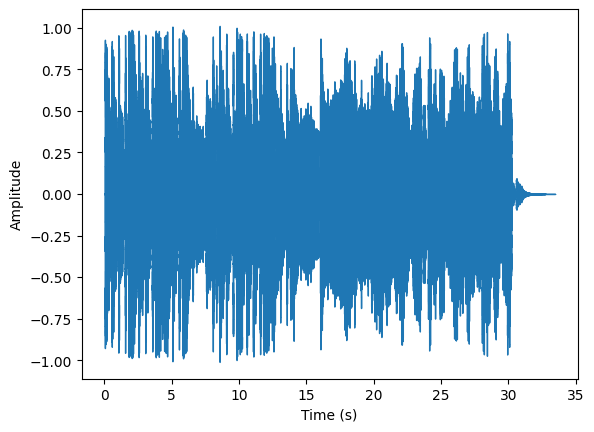

In [6]:
data_root = "../mtg-jamendo-dataset/sample_data/0*/*.mp3"
files = sorted(glob.glob(data_root))
print("Size:", len(files))
waveform, sr = librosa.load(files[0], sr=None, mono=True, offset=0.0, duration=None)
print(sr)
plt.figure()
display.waveshow(y=waveform, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

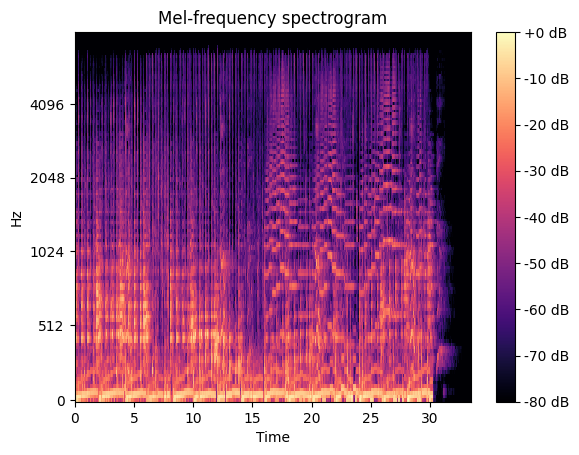

In [7]:
S = librosa.feature.melspectrogram(y=waveform, sr=sr)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

## Dataset construction

In [8]:
import csv
from collections import defaultdict


CATEGORIES = ['genre', 'instrument', 'mood/theme']
TAG_HYPHEN = '---'
METADATA_DESCRIPTION = 'TSV file with such columns: TRACK_ID, ARTIST_ID, ALBUM_ID, PATH, DURATION, TAGS'


def get_id(value):
    return int(value.split('_')[1])


def get_length(values):
    return len(str(max(values)))


def read_file(tsv_file):
    tracks = {}
    tags = defaultdict(dict)

    # For statistics
    artist_ids = set()
    albums_ids = set()

    with open(tsv_file) as fp:
        reader = csv.reader(fp, delimiter='\t')
        next(reader, None)  # skip header
        for row in reader:
            track_id = get_id(row[0])
            tracks[track_id] = {
                'artist_id': get_id(row[1]),
                'album_id': get_id(row[2]),
                'path': row[3],
                'duration': float(row[4]),
                'tags': row[5:],  # raw tags, not sure if will be used
            }
            tracks[track_id].update({category: set() for category in CATEGORIES})

            artist_ids.add(get_id(row[1]))
            albums_ids.add(get_id(row[2]))

            for tag_str in row[5:]:
                category, tag = tag_str.split(TAG_HYPHEN)

                if tag not in tags[category]:
                    tags[category][tag] = set()

                tags[category][tag].add(track_id)

                if category not in tracks[track_id]:
                    tracks[track_id][category] = set()

                tracks[track_id][category].update(set(tag.split(",")))

    print("Reading: {} tracks, {} albums, {} artists".format(len(tracks), len(albums_ids), len(artist_ids)))

    extra = {
        'track_id_length': get_length(tracks.keys()),
        'artist_id_length': get_length(artist_ids),
        'album_id_length': get_length(albums_ids)
    }
    return tracks, tags, extra


def write_file(tracks, tsv_file, extra):
    rows = []
    for track_id, track in tracks.items():
        row = [
            'track_' + str(track_id).zfill(extra['track_id_length']),
            'artist_' + str(track['artist_id']).zfill(extra['artist_id_length']),
            'album_' + str(track['album_id']).zfill(extra['album_id_length']),
            track['path'],
            track['duration']
        ]

        tags = []
        for category in CATEGORIES:
            tags += [category + '---' + tag for tag in track[category]]

        row += sorted(tags)
        rows.append(row)

    with open(tsv_file, 'w') as fp:
        writer = csv.writer(fp, delimiter='\t')
        writer.writerow(['TRACK_ID', 'ARTIST_ID', 'ALBUM_ID', 'PATH', 'DURATION', 'TAGS'])
        for row in rows:
            writer.writerow(row)

tracks, tags, extra = read_file("../mtg-jamendo-dataset/data/autotagging.tsv")

Reading: 55609 tracks, 11262 albums, 3565 artists


In [9]:
paths_dict = collections.defaultdict(str)
for filename in sorted(glob.glob("../mtg-jamendo-dataset/sample_data/0*/*.mp3")):
    paths_dict[filename.split('/')[-2] + '/' + filename.split('/')[-1].split('.')[0] + '.mp3'] = filename
print(len(paths_dict.keys()))
genre_label_dict = collections.defaultdict(list)
# types = set()
for key, val in tracks.items():
    if val['path'] in paths_dict.keys() and val['genre']:
        genre_label_dict[paths_dict[val['path']]] = list(val['genre'])
print(len(genre_label_dict.keys()))

790
780


In [10]:
data = pd.DataFrame.from_dict(genre_label_dict.items())
data.columns = ['path', 'label']
data = pd.concat([data[['path']], pd.get_dummies(data.label.apply(pd.Series).stack()).sum(level=0)], axis=1)
data

/var/folders/c7/1zdkmydd5d73jhqf0mdt_h4h0000gn/T/ipykernel_37957/2337399020.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  data = pd.concat([data[['path']], pd.get_dummies(data.label.apply(pd.Series).stack()).sum(level=0)], axis=1)


,path,60s,70s,80s,90s,acidjazz,african,alternative,alternativerock,ambient,...,soundtrack,swing,symphonic,synthpop,techno,trance,tribal,triphop,world,worldfusion
0,../mtg-jamendo-dataset/sample_data/01/7401.low...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,../mtg-jamendo-dataset/sample_data/01/12101.lo...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,../mtg-jamendo-dataset/sample_data/02/12102.lo...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,../mtg-jamendo-dataset/sample_data/03/12303.lo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../mtg-jamendo-dataset/sample_data/01/16101.lo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,../mtg-jamendo-dataset/sample_data/03/1420603....,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
776,../mtg-jamendo-dataset/sample_data/04/1420604....,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
777,../mtg-jamendo-dataset/sample_data/01/1420701....,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
778,../mtg-jamendo-dataset/sample_data/02/1420702....,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        # assert len(filenames) == len(labels), f'Inconsistent length of filenames and labels.'
        self.config = {}
        self.config['sample_rate'] = 44100
        self.config['hop_length'] = 441
        self.config['n_fft'] = 1024
        self.config['n_mels'] = 128
        self.config['fmin'] = 0
        self.config['fmax'] = 22050
        self.filenames = data['path'].tolist()
        self.data = []
        for file in tqdm(self.filenames):
            waveform, sr = librosa.load(file, sr=self.config['sample_rate'], mono=True, offset=0.0, duration=None)
            assert sr == self.config['sample_rate']
            self.data.append(librosa.feature.melspectrogram(y=waveform,
                                                            sr=self.config['sample_rate'],
                                                            n_fft=self.config['n_fft'],
                                                            hop_length=self.config['hop_length'],
                                                            n_mels=self.config['n_mels'],
                                                            fmin=self.config['fmin'],
                                                            fmax=self.config['fmax']))
        self.length = int((10 * self.config['sample_rate'] + self.config['hop_length'] - 1) // self.config['hop_length'])
        self.labels = data.loc[:, data.columns != 'path'].to_numpy()
        print('Dataset will yield mel spectrogram {} data samples in shape (1, {}, {})'.format(len(self), self.config['n_mels'], self.length))
        # self.transforms = transforms

        # # Calculate length of clip this dataset will make
        # self.sample_length = int((cfg.clip_length * cfg.sample_rate + cfg.hop_length - 1) // cfg.hop_length)

        # # Test with first file
        # assert self[0][0].shape[-1] == self.sample_length, f'Check your files, failed to load {filenames[0]}'

        # # Show basic info.
        # print(f'Dataset will yield log-mel spectrogram {len(self)} data samples in shape [1, {cfg.n_mels}, {self.sample_length}]')

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        assert 0 <= index and index < len(self)
        mel_spec = self.data[index]
        # Padding if sample is shorter than expected - both head & tail are filled with 0s
        pad_size = self.length - mel_spec.shape[-1]
        if pad_size > 0:
            offset = pad_size // 2
            mel_spec = np.pad(mel_spec, ((0, 0), (0, 0), (offset, pad_size - offset)), 'constant')

        # Random crop
        crop_size = mel_spec.shape[-1] - self.length
        if crop_size > 0:
            start = np.random.randint(0, crop_size)
            mel_spec = mel_spec[..., start:start + self.length]
        # # Apply augmentations
        # if self.transforms is not None:
        #     log_mel_spec = self.transforms(log_mel_spec)
        
        return torch.Tensor(mel_spec), self.labels[index]

## Model

In [12]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # self.conv3 = nn.Conv2d(64, 128, 3, 1)
        # self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.pooling = nn.AdaptiveAvgPool2d((8, 8)) # extended
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        # x = self.conv3(x)
        # x = F.relu(x)
        # x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.pooling(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [19]:
def train(model,
          epoch,
          criterion,
          optimizer,
          train_loader):
    accs, losses = [], []
    model.train()
    for _, (input, label) in enumerate(train_loader):
        input, label = input.to(device), label.to(device)
        input = input.unsqueeze(1)
        output = model(input)
        loss = criterion(output, label.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        acc = accuracy(output, label)
        accs.append(acc)
    print("Train - epoch: {}, loss: {}, acc: {}".format(epoch, sum(losses)/len(losses), sum(accs)/len(accs)))
    
    # plotting
    # plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
    # plt.plot(iters, losses, label="Train")
    # plt.xlabel("Iterations")
    # plt.ylabel("Loss")
    # plt.show()
    # plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
    # plt.plot(iters_sub, train_acc, label="Train")
    # plt.plot(iters_sub, val_acc, label="Validation")
    # plt.xlabel("Iterations")
    # plt.ylabel("Accuracy")
    # plt.legend(loc='best')
    # plt.show()
    return model

@torch.no_grad()
def validate(model,
             epoch,
             criterion,
             val_loader):
    losses, accs = [], []
    model.eval()
    for _, (input, label) in enumerate(val_loader):
        input, label = input.to(device), label.to(device)
        input = input.unsqueeze(1)
        output = model(input)
        loss = criterion(output, label.float())
        losses.append(loss)
        acc = accuracy(output, label)
        accs.append(acc)
    print("Validate - epoch: {}, loss: {}, acc: {}".format(epoch, sum(losses)/len(losses), sum(accs)/len(accs)))

def accuracy(output, labels):
    classes = output
    classes[classes >= 1] = 1
    plt.hist(output.detach().numpy())
    return (classes == labels).sum() / len(classes)


# train_network(data, 1e-4, 2)

In [20]:
train_df, val_df = train_test_split(data, random_state=0)
train_dataset = MyDataset(train_df)
val_dataset = MyDataset(val_df)
BS = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BS)

100%|██████████| 585/585 [04:02<00:00,  2.42it/s]


Dataset will yield mel spectrogram 585 data samples in shape (1, 128, 1000)


100%|██████████| 195/195 [01:15<00:00,  2.58it/s]

Dataset will yield mel spectrogram 195 data samples in shape (1, 128, 1000)


  0%|          | 0/2 [00:00<?, ?it/s]

[tensor(11.5925, grad_fn=<DivBackward1>), tensor(13.3468, grad_fn=<DivBackward1>), tensor(11.3909, grad_fn=<DivBackward1>), tensor(9.5434, grad_fn=<DivBackward1>), tensor(12.9862, grad_fn=<DivBackward1>), tensor(11.2881, grad_fn=<DivBackward1>), tensor(11.2068, grad_fn=<DivBackward1>), tensor(13.4934, grad_fn=<DivBackward1>), tensor(10.5196, grad_fn=<DivBackward1>), tensor(12.6171, grad_fn=<DivBackward1>), tensor(11.6601, grad_fn=<DivBackward1>), tensor(11.0154, grad_fn=<DivBackward1>), tensor(11.8731, grad_fn=<DivBackward1>), tensor(12.0199, grad_fn=<DivBackward1>), tensor(9.9878, grad_fn=<DivBackward1>), tensor(12.4742, grad_fn=<DivBackward1>), tensor(10.4264, grad_fn=<DivBackward1>), tensor(9.5120, grad_fn=<DivBackward1>), tensor(12.0926, grad_fn=<DivBackward1>), tensor(12.4902, grad_fn=<DivBackward1>), tensor(12.3204, grad_fn=<DivBackward1>), tensor(10.6704, grad_fn=<DivBackward1>), tensor(11.1723, grad_fn=<DivBackward1>), tensor(12.0630, grad_fn=<DivBackward1>), tensor(11.0482, gr

 50%|█████     | 1/2 [02:08<02:08, 128.83s/it]

Validate - epoch: 0, loss: 11.152974128723145, acc: 0.03846153989434242
[tensor(11.2438, grad_fn=<DivBackward1>), tensor(12.8332, grad_fn=<DivBackward1>), tensor(10.6064, grad_fn=<DivBackward1>), tensor(9.3130, grad_fn=<DivBackward1>), tensor(12.8432, grad_fn=<DivBackward1>), tensor(10.9995, grad_fn=<DivBackward1>), tensor(10.7545, grad_fn=<DivBackward1>), tensor(13.2178, grad_fn=<DivBackward1>), tensor(10.5164, grad_fn=<DivBackward1>), tensor(12.4693, grad_fn=<DivBackward1>), tensor(11.6595, grad_fn=<DivBackward1>), tensor(11.0538, grad_fn=<DivBackward1>), tensor(11.7843, grad_fn=<DivBackward1>), tensor(11.7920, grad_fn=<DivBackward1>), tensor(10.2776, grad_fn=<DivBackward1>), tensor(12.5024, grad_fn=<DivBackward1>), tensor(10.3854, grad_fn=<DivBackward1>), tensor(9.5602, grad_fn=<DivBackward1>), tensor(11.6915, grad_fn=<DivBackward1>), tensor(12.6698, grad_fn=<DivBackward1>), tensor(12.0348, grad_fn=<DivBackward1>), tensor(11.0888, grad_fn=<DivBackward1>), tensor(11.1332, grad_fn=<Di

100%|██████████| 2/2 [04:18<00:00, 129.38s/it]

Validate - epoch: 1, loss: 11.033687591552734, acc: 0.08653846383094788


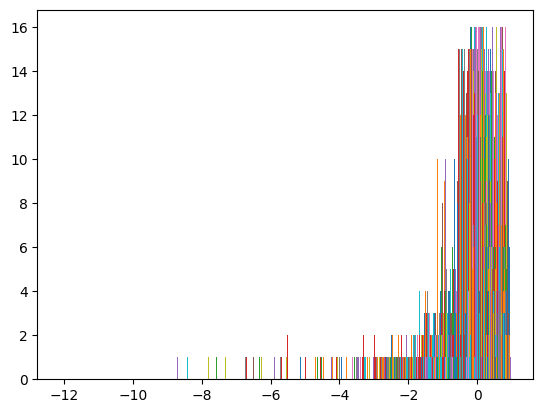

In [21]:
# def train_network(data, learning_rate, num_epochs):
learning_rate = 1e-3
num_epochs = 2
n_classes = len(data.columns) - 1
model = Net(n_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for epoch in tqdm(range(num_epochs)):
    train(model, epoch, criterion, optimizer, train_loader)
    validate(model, epoch, criterion, val_loader)